# Analysing Backtest Performance

In this notebook, we demonstrate the preliminary analysis which has gone in to selecting the take profit and stop loss protocols for the dual class arbitrage trading strategy. 

## Packages, API Login and Time Zone Manipulation

In [1]:
import backtrader as bt
from datetime import datetime as dt, timedelta
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv('API_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')
BASE_URL = os.getenv('BASE_URL')
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

symbol_pair = ('GOOGL', 'GOOG')
eastern = pytz.timezone('US/Eastern')
now_utc = dt.now(pytz.utc)
now_eastern = now_utc.astimezone(eastern)

end_date = (now_eastern - timedelta(hours=12)).isoformat()
start_date = (now_utc - timedelta(days=90)).isoformat()


## Functions to be reused 

In [2]:
def fetch_data(symbol, timeframe, start_date, end_date):
    """Simple function to pull data from Alpaca API"""
    barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date).df
    return barset

def align_data(data0, data1):
    """Function which alings data, by taking common index and removing duplicates"""
    data0 = data0[~data0.index.duplicated(keep='first')]
    data1 = data1[~data1.index.duplicated(keep='first')]
    common_index = data0.index.intersection(data1.index)

    data0_ffill = data0.reindex(common_index).ffill().bfill()
    data1_ffill = data1.reindex(common_index).ffill().bfill()

    data0_aligned = data0_ffill.loc[common_index]
    data1_aligned = data1_ffill.loc[common_index]

    return data0_aligned, data1_aligned

def to_eastern_time(dt, current_tz=None):
    """Convert datetime to Eastern Time, handling naive and aware datetime objects."""
    if dt.tzinfo is None and current_tz is None:
        dt = pd.to_datetime(dt).tz_localize(pytz.utc)  # Assume UTC if not specified
    elif dt.tzinfo is None:
        dt = pd.to_datetime(dt).tz_localize(current_tz)
    return dt.tz_convert(pytz.timezone('US/Eastern'))

def group_trades_into_pairs(trades):
    """Each trade has an entry point and an exit point. This function pairs them and treates them as one trade, which has a side, time of entry and a holding period"""
    trade_pairs = []
    trade_number = 1

    # Iterate through the DataFrame two rows at a time
    for i in range(0, len(trades) - 1, 2):
        start_date = trades.index[i]
        end_date = trades.index[i + 1]
        holding_period = (end_date - start_date).total_seconds() / 3600  # Holding period in hours
        
        trade_pairs.append({
            'Trade_Number': trade_number,
            'Side': trades.iloc[i]['Type'],
            'Stock': trades.iloc[i]['Stock'],
            'Datetime of Entry': start_date,
            'Datetime of Exit': end_date,
            'Holding Period (hours)': holding_period,
            'Entry Price': trades.iloc[i]['Price']
        })
        trade_number += 1

    return pd.DataFrame(trade_pairs).set_index('Trade_Number')

def calculate_position_series(trade_pair, price_data):
    """Take a given trade and holding period and add in all the price data whilst the trade is active"""
    if price_data.index.tz is None:
        price_data.index = pd.to_datetime(price_data.index).tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Eastern'))
    else:
        price_data.index = price_data.index.tz_convert(pytz.timezone('US/Eastern'))
    
    start_date = pd.to_datetime(trade_pair['Datetime of Entry']).tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Eastern'))
    end_date = pd.to_datetime(trade_pair['Datetime of Exit']).tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Eastern'))

    price_data = price_data.sort_index()
    price_series = price_data.loc[start_date:end_date].copy()
    price_series['Side'] = 1 if trade_pair['Side'] == 'BUY' else -1

    return price_series[['close', 'Side']]

def populating_arrays(trade_pairs, price_data):
    """Go through list of trades, apply above function, concat into final df"""
    results = []
    for index, trade in trade_pairs.iterrows():
        trade_number = index[0] if isinstance(index, tuple) else index
        df = calculate_position_series(trade, price_data)
        df.reset_index(inplace=True)
        df['Trade_Number'] = trade_number
        df.columns = [f"{trade_pairs.Stock.iloc[0]}_{col}" if col not in ['timestamp', 'Trade_Number'] else col for col in df.columns]
        results.append(df)
    
    results_df = pd.concat(results)
    results_df.set_index(['Trade_Number', 'timestamp'], inplace=True)
    return results_df

def fractional_moves_df(goog_pairs, googl_pairs, goog_prices, googl_prices):
    """Call above function on both dfs and join into 1, suitable for further analysis"""
    goog_df = populating_arrays(goog_pairs, goog_prices)
    googl_df = populating_arrays(googl_pairs, googl_prices)
    
    # Join the two DataFrames on 'Trade_Number' and 'timestamp'
    final_df = goog_df.join(googl_df, lsuffix='_GOOG', rsuffix='_GOOGL')
    return final_df


def calculate_percentage_move(group):
    """Finds fractional move of trade value since entry, for use in generating the plot seen at the bottom of this notebook"""
    initial_value = group.iloc[0]
    return (group - initial_value) / initial_value * 100



## Analysis of Performance

In [3]:
trade_data = pd.read_csv('trade_log.csv', 
                        index_col= 'Date',
                        parse_dates = ['Date'])

data0 = fetch_data(symbol_pair[0], timeframe='1Min', start_date=start_date, end_date=end_date)
data1 = fetch_data(symbol_pair[1], timeframe='1Min', start_date=start_date, end_date=end_date)

googl_prices, goog_prices = align_data(data0, data1)

In [4]:
# Separate into different DataFrames for GOOG and GOOGL
goog_trades = trade_data[trade_data['Stock'] == 'GOOG']
googl_trades = trade_data[trade_data['Stock'] == 'GOOGL']

# Group the trades into pairs
goog_pairs = group_trades_into_pairs(goog_trades)
googl_pairs = group_trades_into_pairs(googl_trades)

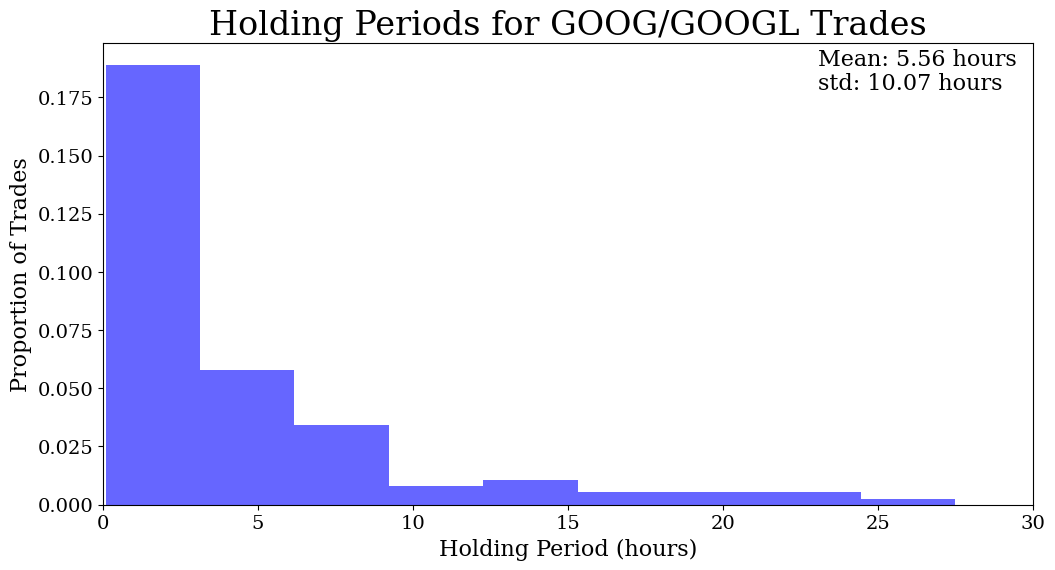

In [9]:
# Sample data from the 'Holding Period (hours)' column
holding_periods = goog_pairs['Holding Period (hours)']

plt.figure(figsize=(12, 6))
plt.hist(holding_periods, bins=20, density=True, alpha=0.6, color='blue', label='GOOG')

plt.xlabel('Holding Period (hours)', font='serif', fontsize=16)
plt.ylabel('Proportion of Trades', font='serif', fontsize=16)
plt.title('Holding Periods for GOOG/GOOGL Trades', font='serif', fontsize=24)
plt.xlim((0, 30))

plt.yticks(font='serif', fontsize=14)
plt.xticks(font='serif', fontsize=14)

# Calculate the mean and display it on the plot
mean_value = np.mean(holding_periods)
std_value = np.std(holding_periods)
plt.text(x=mean_value + 17.5, y=plt.ylim()[1]*0.95, s=f'Mean: {mean_value:.2f} hours', fontsize=16, color='black', font = 'serif')
plt.text(x=mean_value + 17.5, y=plt.ylim()[1]*0.90, s=f'std: {std_value:.2f} hours', fontsize=16, color='black', font = 'serif')
plt.savefig('Average_Holding_period.png', dpi = 400)
plt.show()


## Plots in Price-Time Space

In [12]:
prices = fractional_moves_df(goog_pairs, googl_pairs, goog_prices, googl_prices).iloc[11000:12000]
prices['current_position'] = prices['GOOG_close'] * prices['GOOG_Side'] + prices['GOOGL_close'] * prices['GOOGL_Side']

# Applying earlier function which tells us how any given trade is doing
prices['percentage_move'] = prices.groupby(level='Trade_Number')['current_position'].apply(
    lambda group: calculate_percentage_move(group.reset_index(level='Trade_Number', drop=True))
)

# Adding a column for the time the trade has been open
prices['time_open'] = prices.groupby(level='Trade_Number').cumcount()

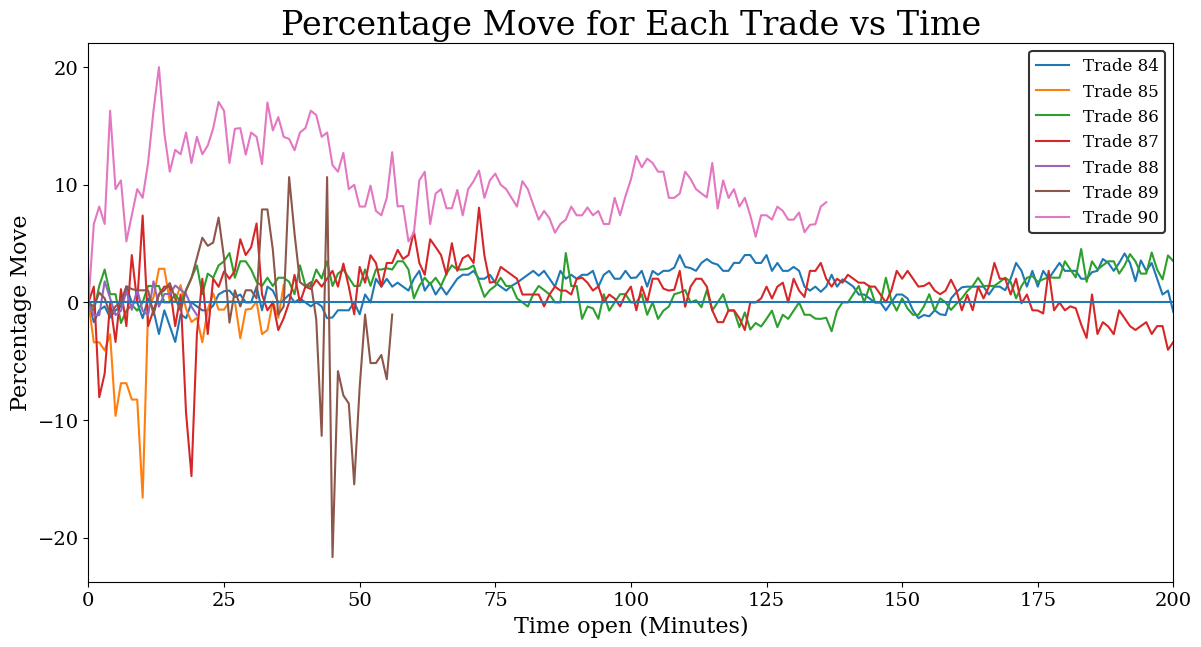

In [13]:
# Plot the percentage move for each trade number
plt.figure(figsize=(14, 7))
for trade_number, group in prices.groupby(level='Trade_Number'):
    plt.plot(group['time_open'], group['percentage_move'], label=f'Trade {trade_number}')
plt.xlabel('Time open (Minutes)', font = 'serif', fontsize = 16)
plt.ylabel('Percentage Move', font = 'serif', fontsize = 16)
plt.title(f'Percentage Move for Each Trade vs Time', font = 'serif', fontsize = 24)
plt.xlim((0, 200))
plt.axhline()
plt.yticks(font = 'serif', fontsize = 14)
plt.xticks(font = 'serif', fontsize = 14)
legend = plt.legend(loc='upper right', prop={'family': 'serif', 'size': 12}, fontsize=12, framealpha = 0.8)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.5)
plt.savefig('Percentage_Moves_vs_time.png', dpi = 400)
plt.show()
